In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import datetime as dt
import pickle

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',60)

In [24]:
def build_dataset(data_store='../data'):
    csv_files_arr = []

    for directory in os.listdir(data_store):
        if directory.startswith(r'.') or directory.endswith('.pkl'):
            continue
        sensor_placement = directory

        for subdirectory in os.listdir(os.path.join(data_store, directory)):
            if subdirectory.startswith(r'.'):
                continue
            if os.path.isfile(os.path.join(data_store, directory, subdirectory)):
                continue

            activity = subdirectory

            for filename in os.listdir(os.path.join(data_store, directory, subdirectory)):
                if filename.endswith('.csv'):
                    user = filename.replace('.csv', '')
                    csv_files_arr.append(
                        [os.path.abspath(os.path.join(data_store, directory, subdirectory, filename)), sensor_placement,
                         activity, user])

    person_data = {}

    for i, row in enumerate(csv_files_arr):
        path = row[0]
        sensor_placement = row[1]
        activity_class = row[2]
        user = row[3]

        if sensor_placement != 'w':
            continue

        if user in person_data:
            activity_data = person_data[user]
        else:
            activity_data = {}

        if activity_class in activity_data:
            activity_df = activity_data[activity_class]
        else:
            activity_df = pd.DataFrame()

        _df = pd.read_csv(path)
        _df['m'] = np.sqrt(np.square(_df['x'].values) + np.square(_df['y'].values) + np.square(_df['z'].values))
        _df['user'] = user
        _df['activity_class'] = activity_class
        _df['epoch'] = _df['time'].apply(lambda x: ((dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f') -
                                                     dt.datetime.utcfromtimestamp(0)).total_seconds()) * 1000)

        try:
            _df.drop(columns=['class'], inplace=True)
        except KeyError:
            pass

        activity_df = pd.concat([activity_df, _df])
        activity_data[activity_class] = activity_df
        person_data[user] = activity_data
    return person_data

person_data = build_dataset()

with open('../data/wrist_dump.pkl', 'wb+') as f:
    pickle.dump(person_data, f)


In [26]:
from math import ceil

_label_map = {'standing': 'sedentary', 'sitting':'sedentary', 'lying':'sedentary', 'jogging':'running', 
              'walk_slow':'walking', 'walk_mod':'walking', 'walk_fast':'walking', 'upstairs':'stairs', 
              'downstairs': 'stairs'}

def build_time_windows(_df, time_len = 10, overlap_ratio = 0.5, min_time_len = 2,
                       sample_rate = 'auto', rate_calcref = 'epoch', sample_rate_multiplier = 1000):
    
    if(sample_rate=='auto'):
        sample_rate = (_df.shape[0]*sample_rate_multiplier)/(_df[rate_calcref].max()-_df[rate_calcref].min())
        
    elif(isinstance(sample_rate, (int,float))):
        raise TypeError("Parameter sample_rate expects int or float unless set to 'auto'; received {}".format(sample_rate))
    
    _twds = []
    
    idxwidth = ceil(sample_rate*time_len)
    min_idxwidth = ceil(sample_rate*min_time_len)
    increment = ceil(idxwidth*(1-overlap_ratio))
    
    n = _df.shape[0]
    i = 0
    
    while i<n:
        start = i
        end = start+idxwidth
        
        if ((end>n) or (n-end < min_idxwidth)):
            end = n-1
            i = n
        
        _dftw = _df.iloc[start:end].copy()
        _dftw['class'] = _dftw['activity_class'].map(_label_map)
        _dftw.drop(columns=['activity_class'],inplace=True)
        _twds.append(_dftw)
        
        i+=increment
        
    return _twds

time_windows = []

for person, activity_data in person_data.items():
    for activity, activity_df in activity_data.items():
        time_windows.append(build_time_windows(activity_df))



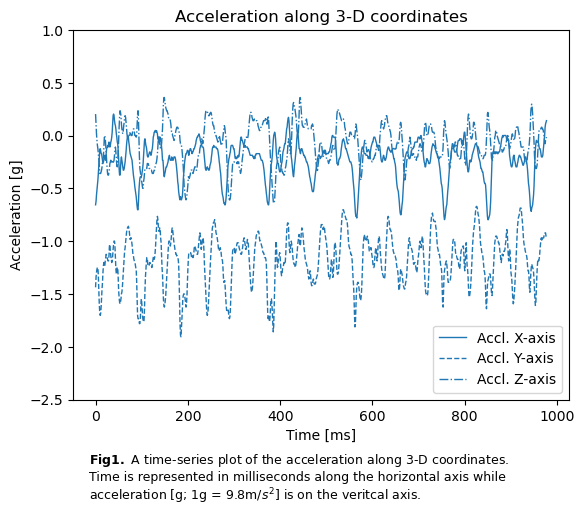

In [92]:
temp_df = time_windows[12][0]
x = temp_df['x']
y = temp_df['y']
z = temp_df['z']
m = temp_df['m']

fig,ax = plt.subplots()
ax.plot(np.linspace(0,x.size-1,x.size),temp_df['x'],color='tab:blue',lw=1,label='Accl. X-axis')
ax.plot(np.linspace(0,y.size-1,y.size),temp_df['y'],color='tab:blue',linestyle='--',lw=1,label='Accl. Y-axis')
ax.plot(np.linspace(0,z.size-1,z.size),temp_df['z'],color='tab:blue',linestyle='-.',lw=1,label='Accl. Z-axis')
# ax.plot(np.linspace(0,m.size-1,m.size),temp_df['m'],color='tab:green',lw=1.5,label='Accl. Magnitude')
ax.legend(loc='lower right')
ax.set_ylim(-2.5,1)

ax.set_title('Acceleration along 3-D coordinates')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Acceleration [g]')

caption_text = r"""$\bf{Fig 1.}$ A time-series plot of the acceleration along 3-D coordinates. 
Time is represented in milliseconds along the horizontal axis while 
acceleration [g; 1g = 9.8m/$s^{2}$] is on the veritcal axis."""

plt.figtext(0.15, -0.1, caption_text, wrap=False, horizontalalignment='left', 
            fontsize=9)

plt.savefig('tempfig.png')

In [29]:
# defining time domain features

def build_time_domain_features(time_windows):

    def td_sum(x):
        return np.sum(x)

    def td_mean(x):
        return np.mean(x)

    def td_std(x):
        return np.std(x)

    def td_percentile(x,p):
        return np.percentile(x,p)

    def td_iqr(x):
        return np.percentile(x,75)-np.percentile(x,25)

    def td_range(x):
        return np.max(x)-np.min(x)

    def td_power(x):
        return np.sum(np.square(x))

    def td_log_power(x, eps=10e-6):
        x = np.add(x,eps)
        return np.sum(np.log(np.square(x)))

    def td_energy(x, y, z):
        ex = np.sqrt(np.sum(np.square(np.subtract(x,np.mean(x)))))
        ey = np.sqrt(np.sum(np.square(np.subtract(y,np.mean(y)))))
        ez = np.sqrt(np.sum(np.square(np.subtract(z,np.mean(z)))))

        e = (1/(3 * len(x))) * (ex + ey + ez)
        return e
    
    def td_rms(x):
        return np.sqrt(np.mean(np.square(x)))


    time_domain_func = [td_sum, td_mean, td_std, td_iqr, td_range, td_power, td_log_power, td_rms, td_energy]
    time_domain_col = ['epoch_start','epoch_end','user','class']

    for func in time_domain_func:
        if(func in [td_energy]):
            time_domain_col.append(func.__name__)
            continue
        for axis in ['x','y','z','m']:
            time_domain_col.append(func.__name__+'_'+axis)

    time_domain_features = []

    for useract_winset in time_windows:
        for twdf in useract_winset:
            twdf_features = []
            twdf_features.extend([twdf['epoch'].min(), twdf['epoch'].max(), 
                                 twdf['user'].unique()[0], twdf['class'].unique()[0]])

            for func in time_domain_func:
                if(func in [td_energy]):
                    twdf_features.extend([func(twdf['x'].values, twdf['y'].values, twdf['z'].values)])
                    continue
                twdf_features.extend([func(twdf['x'].values), func(twdf['y'].values), 
                                      func(twdf['z'].values), func(twdf['m'].values)])

            time_domain_features.append(twdf_features)

    time_domain_df = pd.DataFrame(time_domain_features, columns=time_domain_col)
    return time_domain_df
    
time_domain_df = build_time_domain_features(time_windows)
time_domain_df

,epoch_start,epoch_end,user,class,td_sum_x,td_sum_y,td_sum_z,td_sum_m,td_mean_x,td_mean_y,td_mean_z,td_mean_m,td_std_x,td_std_y,td_std_z,td_std_m,td_iqr_x,td_iqr_y,td_iqr_z,td_iqr_m,td_range_x,td_range_y,td_range_z,td_range_m,td_power_x,td_power_y,td_power_z,td_power_m,td_log_power_x,td_log_power_y,td_log_power_z,td_log_power_m,td_rms_x,td_rms_y,td_rms_z,td_rms_m,td_energy
0,1.461149e+12,1.461149e+12,034,stairs,-338.875000,-940.234375,-107.218750,1038.139884,-0.347564,-0.964343,-0.109968,1.064759,0.260323,0.377101,0.183482,0.415666,0.226562,0.460938,0.187500,0.498218,2.390625,1.937500,1.640625,2.099636,183.854492,1045.358154,44.614746,1273.827393,-2400.145856,-204.390575,-5805.100453,-10.259216,0.434245,1.035453,0.213913,1.143018,0.008763
1,1.461149e+12,1.461149e+12,034,stairs,-316.109375,-946.656250,-108.203125,1040.468241,-0.324215,-0.970929,-0.110978,1.067147,0.261514,0.368025,0.180813,0.397314,0.250000,0.484375,0.203125,0.508525,2.781250,1.953125,1.453125,2.016667,169.167236,1051.192871,43.884033,1264.244141,-2570.470164,-186.076819,-5653.900424,3.568909,0.416539,1.038338,0.212154,1.138710,0.008651
2,1.461149e+12,1.461149e+12,034,stairs,-311.218750,-946.265625,-117.875000,1034.081133,-0.319199,-0.970529,-0.120897,1.060596,0.215161,0.322750,0.181061,0.341776,0.203125,0.343750,0.203125,0.423340,2.390625,1.765625,1.437500,1.649355,144.477539,1019.941162,46.214355,1210.633057,-2598.059826,-154.847474,-4989.097434,24.533427,0.384944,1.022787,0.217714,1.114305,0.007675
3,1.461149e+12,1.461149e+12,034,stairs,-290.687500,-948.281250,-140.656250,1032.910278,-0.298141,-0.972596,-0.144263,1.059395,0.211231,0.303750,0.168489,0.314001,0.187500,0.296875,0.210938,0.288431,1.937500,1.703125,1.125000,1.718577,130.168945,1012.252441,47.970215,1190.391602,-2539.890283,-140.682956,-4527.122899,35.874748,0.365386,1.018925,0.221811,1.104950,0.007296
4,1.461149e+12,1.461149e+12,034,stairs,-323.875000,-933.843750,-103.156250,1028.847612,-0.332179,-0.957788,-0.105801,1.055228,0.239908,0.319935,0.167989,0.336932,0.250000,0.367188,0.203125,0.353418,1.937500,1.609375,1.218750,1.718577,163.701660,994.224121,38.428711,1196.354492,-2399.338411,-184.820264,-5024.393563,13.861764,0.409755,1.009810,0.198530,1.107714,0.007770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9376,1.461765e+12,1.461765e+12,039,walking,-289.671875,-1079.046875,259.593750,1197.087421,-0.296491,-1.104449,0.265705,1.225269,0.283011,0.176167,0.233281,0.206351,0.265625,0.203125,0.328125,0.270163,2.187500,1.265625,1.296875,1.300414,164.137939,1222.073486,122.143555,1508.354980,-2630.294177,169.538976,-3494.025961,369.522291,0.409880,1.118411,0.353580,1.242523,0.007385
9377,1.461765e+12,1.461765e+12,039,walking,-283.062500,-1088.968750,220.718750,1198.461892,-0.289726,-1.114605,0.225915,1.226675,0.295041,0.197856,0.220886,0.218120,0.265625,0.218750,0.312500,0.293856,2.484375,1.312500,1.437500,1.390373,167.057617,1252.016113,97.532227,1516.605957,-2675.218646,181.210782,-3836.528203,368.732755,0.413510,1.132029,0.315956,1.245917,0.007612
9378,1.461765e+12,1.461765e+12,039,walking,-361.531250,-1023.578125,215.984375,1172.406654,-0.370042,-1.047675,0.221069,1.200007,0.298819,0.248400,0.244612,0.232893,0.281250,0.296875,0.328125,0.300131,2.500000,1.484375,1.687500,1.311176,221.020996,1132.660400,106.206299,1459.887695,-2290.130953,28.497101,-3591.193035,318.382866,0.475630,1.076719,0.329707,1.222397,0.008444
9379,1.461765e+12,1.461765e+12,039,walking,-431.859375,-914.015625,232.562500,1090.999539,-0.442026,-0.935533,0.238037,1.116683,0.255339,0.232909,0.227098,0.226511,0.296875,0.328125,0.281250,0.314405,1.750000,1.531250,1.546875,1.665688,254.591553,908.090576,105.746094,1268.428223,-1910.737916,-211.920665,-3321.712152,174.479153,0.510475,0.964089,0.328992,1.139425,0.007629


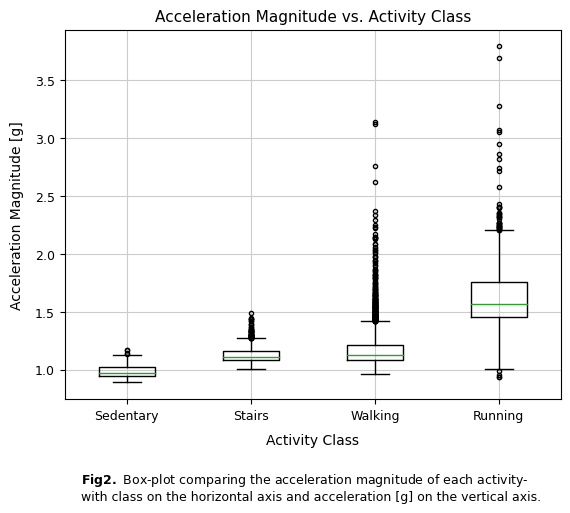

In [93]:
td_power_group_df = time_domain_df.groupby(['class']).agg({'td_mean_m': lambda x: list(x)})
td_power_group_df = td_power_group_df.reset_index().set_index('class')
class_custom_order = {'sedentary':0,'stairs':1,'walking':2,'running':3}
td_power_group_df = td_power_group_df.sort_values(by=['class'],key= lambda x: x.map(class_custom_order))
td_power_group_dict = td_power_group_df.to_dict()['td_mean_m']
td_power_group_dict

fig,ax = plt.subplots()
bp = ax.boxplot(td_power_group_dict.values(),sym='.',medianprops=dict(color='tab:green'))
plt.title('Acceleration Magnitude vs. Activity Class',fontsize=11)
ax.tick_params(axis='both', which='major',labelsize=9)

# format ticks, tick labels, axis labels
ax.set_ylabel('Acceleration Magnitude [g]',fontsize=10,labelpad=8)
ax.set_xticklabels(['Sedentary','Stairs','Walking','Running'],fontdict=dict(fontsize=9))
ax.set_xlabel('Activity Class',fontsize=10,labelpad=8)

caption_text = r"""$\bf{Fig 2.}$ Box-plot comparing the acceleration magnitude of each activity- 
with class on the horizontal axis and acceleration [g] on the vertical 
axis. """

plt.grid(visible=True, which='major', color='0.8', linestyle='-')
ax.text(0.15, -0.1, caption_text, wrap=False, horizontalalignment='left', 
            fontsize=9, transform=fig.transFigure)

plt.show()


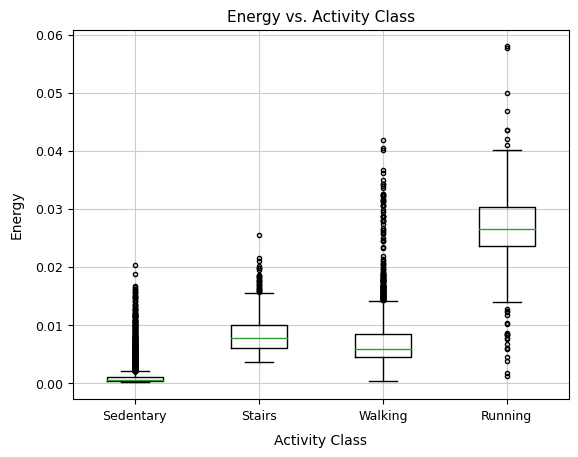

In [31]:
td_power_group_df = time_domain_df.groupby(['class']).agg({'td_energy': lambda x: list(x)})
td_power_group_df = td_power_group_df.reset_index().set_index('class')
class_custom_order = {'sedentary':0,'stairs':1,'walking':2,'running':3}
td_power_group_df = td_power_group_df.sort_values(by=['class'],key= lambda x: x.map(class_custom_order))
td_power_group_dict = td_power_group_df.to_dict()['td_energy']
td_power_group_dict

fig,ax = plt.subplots()
bp = ax.boxplot(td_power_group_dict.values(),sym='.',medianprops=dict(color='tab:green'))
plt.title('Energy vs. Activity Class',fontsize=11)
ax.tick_params(axis='both', which='major',labelsize=9)

# format ticks, tick labels, axis labels
ax.set_ylabel('Energy',fontsize=10,labelpad=8)
ax.set_xticklabels(['Sedentary','Stairs','Walking','Running'],fontdict=dict(fontsize=9))
ax.set_xlabel('Activity Class',fontsize=10,labelpad=8)

plt.grid(visible=True, which='major', color='0.8', linestyle='-')
plt.show()


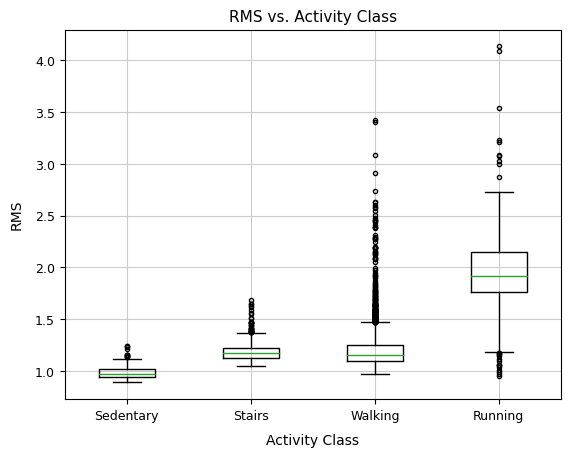

In [32]:
td_power_group_df = time_domain_df.groupby(['class']).agg({'td_rms_m': lambda x: list(x)})
td_power_group_df = td_power_group_df.reset_index().set_index('class')
class_custom_order = {'sedentary':0,'stairs':1,'walking':2,'running':3}
td_power_group_df = td_power_group_df.sort_values(by=['class'],key= lambda x: x.map(class_custom_order))
td_power_group_dict = td_power_group_df.to_dict()['td_rms_m']
td_power_group_dict

fig,ax = plt.subplots()
bp = ax.boxplot(td_power_group_dict.values(),sym='.',medianprops=dict(color='tab:green'))
plt.title('RMS vs. Activity Class',fontsize=11)
ax.tick_params(axis='both', which='major',labelsize=9)

# format ticks, tick labels, axis labels
ax.set_ylabel('RMS',fontsize=10,labelpad=8)
ax.set_xticklabels(['Sedentary','Stairs','Walking','Running'],fontdict=dict(fontsize=9))
ax.set_xlabel('Activity Class',fontsize=10,labelpad=8)

plt.grid(visible=True, which='major', color='0.8', linestyle='-')
plt.show()


In [33]:
from detecta import detect_peaks
from scipy.signal import butter, lfilter

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'p%s' % n
    return percentile_

def build_freq_domain_features(time_windows):

    def fd_dominant_freq(x, t):
        """Returns the dominant frequency of x in Hz."""
        n = x.size
        dt = t/n
        df = 1/t
        
        X = np.fft.fft(x)
        freqs = np.fft.fftfreq(n)*n*df
        
        if n%2==0:
            eff_size = int(n/2)
        else:
            eff_size = int((n+1)/2)
        
        idx = np.argmax(np.abs(X[1:eff_size]))
        freq = freqs[1:eff_size][idx]
        return freq
    
    def fd_spectral_entropy(x):
        """Returns the spectral entropy of a signal"""
        n = x.size
        p = np.square(x)/n
        pi = p/np.sum(p) + 1e-15
        H = -np.sum(pi*np.log2(pi))/(np.log2(n))
        return H
    
    def fd_step_counter(m):
        """Estimates number of steps based on number of peaks in the mag vector"""
        
        def _filter_signal(x, samp_rate=100, high=2, order=5):
            nyq = 0.5 * samp_rate    
            high = high/nyq
            b, a = butter(order, high)
            y = lfilter(b, a, x)
            return y
        
        y = _filter_signal(m, samp_rate=100, high=2)
        peaks = detect_peaks(y, mph=1.2)
        steps = len(peaks)
        return steps
    
    
    freq_domain_func = [fd_dominant_freq, fd_step_counter, fd_spectral_entropy]
    freq_domain_col = ['epoch_start','epoch_end','user','class']

    for func in freq_domain_func:
        for axis in ['x','y','z','m']:
            freq_domain_col.append(func.__name__+'_'+axis)

    freq_domain_features = []

    for useract_winset in time_windows:
        for twdf in useract_winset:
            twdf_features = []
            twdf_features.extend([twdf['epoch'].min(), twdf['epoch'].max(), 
                                  twdf['user'].unique()[0], twdf['class'].unique()[0]])
            
            signal_secs = (twdf['epoch'].max()-twdf['epoch'].min())/1000

            for func in freq_domain_func:
                if func in [fd_dominant_freq]:
                    twdf_features.extend([func(twdf['x'].values, signal_secs), func(twdf['y'].values, signal_secs), 
                                          func(twdf['z'].values, signal_secs), func(twdf['m'].values, signal_secs)])
                else:
                    twdf_features.extend([func(twdf['x'].values), func(twdf['y'].values),
                                          func(twdf['z'].values), func(twdf['m'].values)])

            freq_domain_features.append(twdf_features)

    freq_domain_df = pd.DataFrame(freq_domain_features, columns=freq_domain_col)
    return freq_domain_df
    
freq_domain_df = build_freq_domain_features(time_windows)
freq_domain_df


/var/folders/hz/mq1t9krj4kv9cxjz4g5c_p8c0000gn/T/ipykernel_36348/1141640934.py:34: RuntimeWarning: invalid value encountered in true_divide
  pi = p/np.sum(p) + 1e-15


,epoch_start,epoch_end,user,class,fd_dominant_freq_x,fd_dominant_freq_y,fd_dominant_freq_z,fd_dominant_freq_m,fd_step_counter_x,fd_step_counter_y,fd_step_counter_z,fd_step_counter_m,fd_spectral_entropy_x,fd_spectral_entropy_y,fd_spectral_entropy_z,fd_spectral_entropy_m
0,1.461149e+12,1.461149e+12,034,stairs,2.000600,1.700510,1.500450,1.700510,0,0,0,13,0.908280,0.958818,0.836516,0.958852
1,1.461149e+12,1.461149e+12,034,stairs,3.501751,1.700850,1.700850,1.700850,0,0,0,13,0.916588,0.961436,0.859245,0.962591
2,1.461149e+12,1.461149e+12,034,stairs,3.402382,1.701191,1.701191,1.701191,0,0,0,13,0.931042,0.969089,0.875511,0.970831
3,1.461149e+12,1.461149e+12,034,stairs,2.299540,1.599680,1.599680,1.599680,0,0,0,12,0.944229,0.972427,0.906565,0.974805
4,1.461149e+12,1.461149e+12,034,stairs,3.102172,1.501051,1.601121,1.501051,0,0,0,13,0.937462,0.969243,0.883607,0.971535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9376,1.461765e+12,1.461765e+12,039,walking,1.001603,1.001603,1.001603,1.001603,0,0,0,14,0.923104,0.992680,0.897571,0.991896
9377,1.461765e+12,1.461765e+12,039,walking,1.101652,2.303455,1.101652,2.103155,0,0,0,14,0.915709,0.991012,0.880345,0.990959
9378,1.461765e+12,1.461765e+12,039,walking,1.001101,0.100110,1.001101,0.100110,0,0,0,12,0.923322,0.985195,0.886997,0.989508
9379,1.461765e+12,1.461765e+12,039,walking,1.000600,2.101261,1.000600,2.101261,0,0,0,11,0.937281,0.984211,0.906135,0.988520


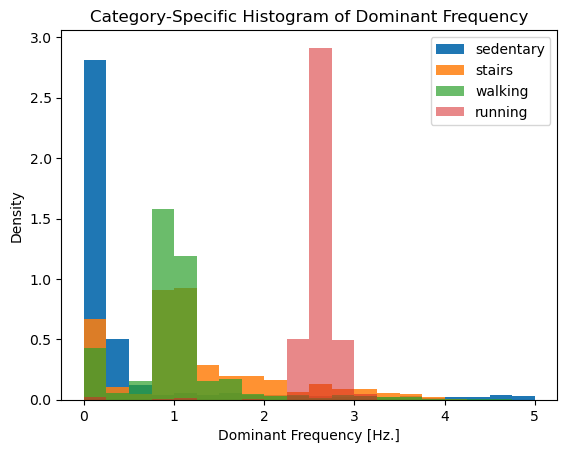

In [36]:
cat_hist_df = freq_domain_df.sort_values(['class'],key= lambda x: x.map(class_custom_order))
classes = cat_hist_df['class'].unique()

for i,c in enumerate(classes):
    plt.hist(cat_hist_df[cat_hist_df['class']==c]['fd_dominant_freq_x'], alpha=1-i*0.15, label=c,
             density=True, bins=20, range=(0,5))
plt.title('Category-Specific Histogram of Dominant Frequency')
plt.xlabel('Dominant Frequency [Hz.]')
plt.ylabel('Density')
plt.legend()
plt.show()


In [37]:
time_freq_domain_df = pd.merge(left=time_domain_df, right=freq_domain_df, left_index=True, right_index=True,
                               how='outer', suffixes=('','_drop'))
time_freq_domain_df.drop(columns=[col_name for col_name in time_freq_domain_df.columns if '_drop' in col_name],inplace=True)
time_freq_domain_df


,epoch_start,epoch_end,user,class,td_sum_x,td_sum_y,td_sum_z,td_sum_m,td_mean_x,td_mean_y,td_mean_z,td_mean_m,td_std_x,td_std_y,td_std_z,td_std_m,td_iqr_x,td_iqr_y,td_iqr_z,td_iqr_m,td_range_x,td_range_y,td_range_z,td_range_m,td_power_x,td_power_y,td_power_z,td_power_m,td_log_power_x,td_log_power_y,td_log_power_z,td_log_power_m,td_rms_x,td_rms_y,td_rms_z,td_rms_m,td_energy,fd_dominant_freq_x,fd_dominant_freq_y,fd_dominant_freq_z,fd_dominant_freq_m,fd_step_counter_x,fd_step_counter_y,fd_step_counter_z,fd_step_counter_m,fd_spectral_entropy_x,fd_spectral_entropy_y,fd_spectral_entropy_z,fd_spectral_entropy_m
0,1.461149e+12,1.461149e+12,034,stairs,-338.875000,-940.234375,-107.218750,1038.139884,-0.347564,-0.964343,-0.109968,1.064759,0.260323,0.377101,0.183482,0.415666,0.226562,0.460938,0.187500,0.498218,2.390625,1.937500,1.640625,2.099636,183.854492,1045.358154,44.614746,1273.827393,-2400.145856,-204.390575,-5805.100453,-10.259216,0.434245,1.035453,0.213913,1.143018,0.008763,2.000600,1.700510,1.500450,1.700510,0,0,0,13,0.908280,0.958818,0.836516,0.958852
1,1.461149e+12,1.461149e+12,034,stairs,-316.109375,-946.656250,-108.203125,1040.468241,-0.324215,-0.970929,-0.110978,1.067147,0.261514,0.368025,0.180813,0.397314,0.250000,0.484375,0.203125,0.508525,2.781250,1.953125,1.453125,2.016667,169.167236,1051.192871,43.884033,1264.244141,-2570.470164,-186.076819,-5653.900424,3.568909,0.416539,1.038338,0.212154,1.138710,0.008651,3.501751,1.700850,1.700850,1.700850,0,0,0,13,0.916588,0.961436,0.859245,0.962591
2,1.461149e+12,1.461149e+12,034,stairs,-311.218750,-946.265625,-117.875000,1034.081133,-0.319199,-0.970529,-0.120897,1.060596,0.215161,0.322750,0.181061,0.341776,0.203125,0.343750,0.203125,0.423340,2.390625,1.765625,1.437500,1.649355,144.477539,1019.941162,46.214355,1210.633057,-2598.059826,-154.847474,-4989.097434,24.533427,0.384944,1.022787,0.217714,1.114305,0.007675,3.402382,1.701191,1.701191,1.701191,0,0,0,13,0.931042,0.969089,0.875511,0.970831
3,1.461149e+12,1.461149e+12,034,stairs,-290.687500,-948.281250,-140.656250,1032.910278,-0.298141,-0.972596,-0.144263,1.059395,0.211231,0.303750,0.168489,0.314001,0.187500,0.296875,0.210938,0.288431,1.937500,1.703125,1.125000,1.718577,130.168945,1012.252441,47.970215,1190.391602,-2539.890283,-140.682956,-4527.122899,35.874748,0.365386,1.018925,0.221811,1.104950,0.007296,2.299540,1.599680,1.599680,1.599680,0,0,0,12,0.944229,0.972427,0.906565,0.974805
4,1.461149e+12,1.461149e+12,034,stairs,-323.875000,-933.843750,-103.156250,1028.847612,-0.332179,-0.957788,-0.105801,1.055228,0.239908,0.319935,0.167989,0.336932,0.250000,0.367188,0.203125,0.353418,1.937500,1.609375,1.218750,1.718577,163.701660,994.224121,38.428711,1196.354492,-2399.338411,-184.820264,-5024.393563,13.861764,0.409755,1.009810,0.198530,1.107714,0.007770,3.102172,1.501051,1.601121,1.501051,0,0,0,13,0.937462,0.969243,0.883607,0.971535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9376,1.461765e+12,1.461765e+12,039,walking,-289.671875,-1079.046875,259.593750,1197.087421,-0.296491,-1.104449,0.265705,1.225269,0.283011,0.176167,0.233281,0.206351,0.265625,0.203125,0.328125,0.270163,2.187500,1.265625,1.296875,1.300414,164.137939,1222.073486,122.143555,1508.354980,-2630.294177,169.538976,-3494.025961,369.522291,0.409880,1.118411,0.353580,1.242523,0.007385,1.001603,1.001603,1.001603,1.001603,0,0,0,14,0.923104,0.992680,0.897571,0.991896
9377,1.461765e+12,1.461765e+12,039,walking,-283.062500,-1088.968750,220.718750,1198.461892,-0.289726,-1.114605,0.225915,1.226675,0.295041,0.197856,0.220886,0.218120,0.265625,0.218750,0.312500,0.293856,2.484375,1.312500,1.437500,1.390373,167.057617,1252.016113,97.532227,1516.605957,-2675.218646,181.210782,-3836.528203,368.732755,0.413510,1.132029,0.315956,1.245917,0.007612,1.101652,2.303455,1.101652,2.103155,0,0,0,14,0.915709,0.991012,0.880345,0.990959
9378,1.4617

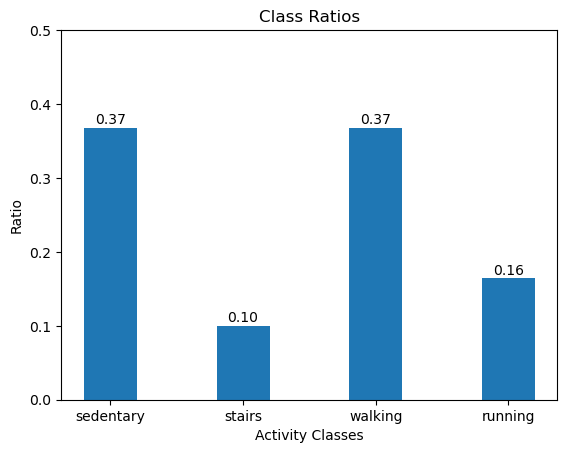

In [38]:
class_custom_order = {'sedentary':0,'stairs':1,'walking':2,'running':3}
class_balance = time_freq_domain_df['class'].value_counts()/time_freq_domain_df['class'].value_counts().sum()
class_balance.sort_index(key=lambda x: x.map(class_custom_order),inplace=True)

fig,ax = plt.subplots()
ax.bar(x=class_balance.index, height=class_balance.values, width=0.4)
ax.set_title('Class Ratios')
ax.set_xlabel('Activity Classes')
ax.set_ylabel('Ratio')
ax.set_ylim(0,0.5)

rects = ax.patches

# Make some labels.
labels = ['{:.02f}'.format(i) for i in class_balance.values]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.001, label, ha="center", va="bottom")

plt.show()

In [40]:
def build_label_color_map(class_labels, color_map=plt.cm.tab10):
    label_color_map = {}
    for i,label in enumerate(class_labels):
        label_color_map[label] = color_map(i)
    return label_color_map

def build_colormap(labels_arr, label_color_map):
    color_arr = []
    for label in labels_arr:
        color_arr.append(label_color_map[label])
    return color_arr


label_color_map = build_label_color_map(class_labels = time_freq_domain_df['class'].unique().tolist())




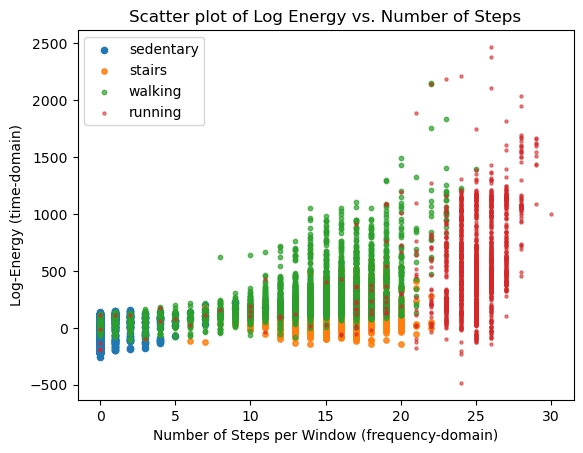

In [41]:
class_custom_order = {'sedentary':0,'stairs':1,'walking':2,'running':3}
cat_scat_df = time_freq_domain_df.sort_values(['class'],key= lambda x: x.map(class_custom_order))
classes = cat_scat_df['class'].unique()

fig, ax = plt.subplots()

for i,c in enumerate(classes):
    ax.scatter(cat_scat_df[cat_scat_df['class']==c]['fd_step_counter_m'], 
                cat_scat_df[cat_scat_df['class']==c]['td_log_power_m'],
                alpha=1-i*0.15, label=c, s=20-i*5)
    
ax.set_title('Scatter plot of Log Energy vs. Number of Steps')
ax.set_xlabel('Number of Steps per Window (frequency-domain)')
ax.set_ylabel('Log-Energy (time-domain)')
ax.legend()
plt.show()